# Modelling Itokawa with mascons

From blender we import the asteroid gsl model, rescale it to 0.01 its size, and run the following script in the python scripting window of a Windows installation of blender 2.82. 

```python 
import pickle as pk
mesh = C.selected_objects[0].data
polygons = mesh.polygons
vertices = mesh.vertices
loops = mesh.loops
points = [[v.co.x, v.co.y, v.co.z] for v in vertices]
triangles = [[loops[id].vertex_index for id in range(poly.loop_start, poly.loop_start + poly.loop_total)] for poly  in polygons] 
with open(r"C:\Users\USER NAME\Desktop\Itokawa.pk", "wb") as file:
    pk.dump((points, triangles), file)
```

Its important that the above script is run in the blender python only after the asetroid has been selected.

The algorithms to deal with the 3D mesh are those containied in tetgen and pyvista. In your conda environment,
install those via pip:
```bash
pip install tetgen
```
The above line should take care of both

In [1]:
# core stuff
import pickle as pk
import numpy as np

# meshing
import pyvista as pv
import tetgen

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

#misc
import sobol_seq
from scipy import spatial

## Importing the 2D mesh
We open the file we pickled and read the mesh we exported from blender

In [2]:
with open("../3dmeshes/Itokawa.pk", "rb") as f:
    points, triangles = pk.load(f)
points = np.array(points)
triangles = np.array(triangles)

<IPython.core.display.Javascript object>


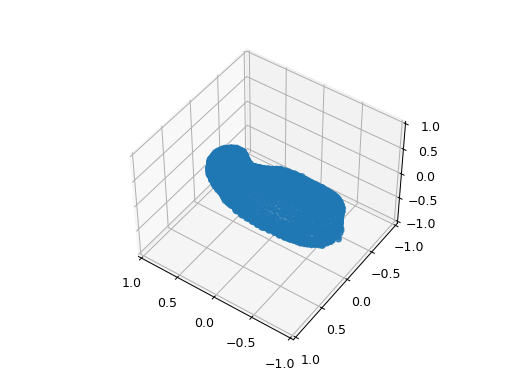

(-1.0, 1.0)

In [3]:
# Visualizing the vertices
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], alpha=0.8)
ax.view_init(elev=45., azim=125.)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

## Generating a 3D thetraedrical grid

In [4]:
# Here we define the surface
tgen = tetgen.TetGen(points, triangles)
# Here we run the algorithm to mesh the inside with thetrahedrons
nodes, elems = tgen.tetrahedralize()

 ... and now we visualize the results

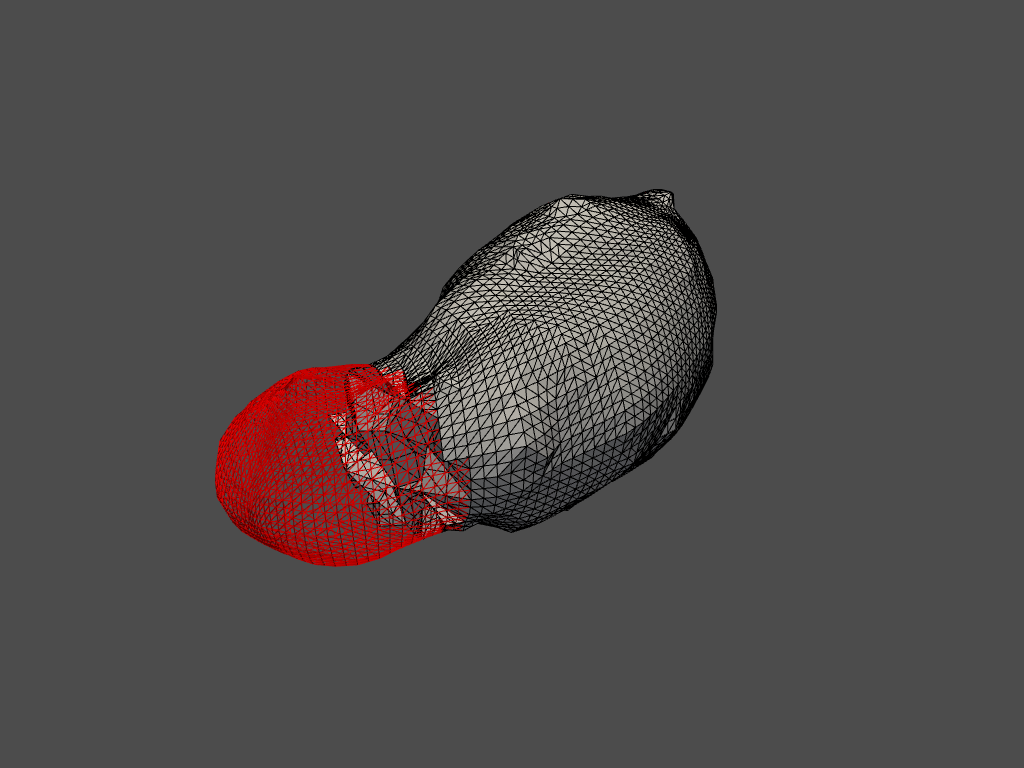

In [11]:
# get all cell centroids
grid = tgen.grid
cell_center = grid.cell_centers().points

# makes a section on x
mask = cell_center[:, 0] < 0.4
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid, 'r', 'wireframe')
plotter.show()

<IPython.core.display.Javascript object>


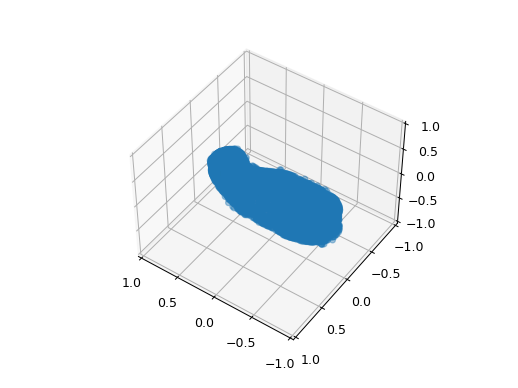

(-1.0, 1.0)

In [9]:
# Visualizing the mascon model
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cell_center[:,0], cell_center[:,1], cell_center[:,2], alpha=0.4)
ax.view_init(elev=45., azim=125.)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

In [22]:
grid = grid.compute_cell_sizes(volume=True, area=False, length=False)

In [29]:
mascon_points = np.array(grid.cell_centers().points)
mascon_masses = grid["Volume"]
# We here divide the mascons mass into two categories (<0.35)
mascon_masses = mascon_masses * 2850.
mascon_masses[mask] *= 1750. / 2850.
mascon_masses = mascon_masses/sum(mascon_masses)

In [30]:
with open("../mascons/Itokawa_non_uniform.pk", "wb") as file:
    pk.dump((mascon_points, mascon_masses, "Itokawa_non_uniform"), file)